<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/preprocess/src/Testeo%20Temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes - Temperatura

Una vez que los datos son alistados, se realiza el análisis de testes. 

Para temperatura, se consideran los siguientes testes:

- Test de rango fijo
- Tests de consistencia interna
- Test de ceros
- Test para el salto térmico diario
- Tests de rango dinámico, consistencia temporal, persistencia y coherencia espacial

In [18]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'

# NOMBRE_ESTACION = 'chucuri'
NOMBRE_ESTACION = 'palanquero'
# NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/'
PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado.csv'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_temp.csv'


In [20]:
df = pd.read_csv(PATH_FINAL_DADOS + FILE_DATOS_PROCESADOS, 
                 sep = ';', 
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfTemp = df[['FECHA', 'TEMP']].copy()
dfTemp = dfTemp.sort_values(by=['FECHA']).reset_index(drop = True)
dfTemp

,FECHA,TEMP
0,2011-01-01 01:00:00-05:00,22.7
1,2011-01-01 02:00:00-05:00,23.1
2,2011-01-01 03:00:00-05:00,23.3
3,2011-01-01 04:00:00-05:00,24.1
4,2011-01-01 05:00:00-05:00,22.9
...,...,...
48875,2017-12-31 19:00:00-05:00,25.2
48876,2017-12-31 20:00:00-05:00,24.4
48877,2017-12-31 21:00:00-05:00,23.9
48878,2017-12-31 22:00:00-05:00,24.0


## Test de rango fijo

In [21]:
t_max = 50.
t_min = 15.
lamb_func = lambda r: np.nan if ((r > t_max) | (r < t_min)) else r
dfTemp['TEMP_RANGO_FIJO'] = dfTemp['TEMP'].apply(lamb_func)
dfTemp

,FECHA,TEMP,TEMP_RANGO_FIJO
0,2011-01-01 01:00:00-05:00,22.7,22.7
1,2011-01-01 02:00:00-05:00,23.1,23.1
2,2011-01-01 03:00:00-05:00,23.3,23.3
3,2011-01-01 04:00:00-05:00,24.1,24.1
4,2011-01-01 05:00:00-05:00,22.9,22.9
...,...,...,...
48875,2017-12-31 19:00:00-05:00,25.2,25.2
48876,2017-12-31 20:00:00-05:00,24.4,24.4
48877,2017-12-31 21:00:00-05:00,23.9,23.9
48878,2017-12-31 22:00:00-05:00,24.0,24.0


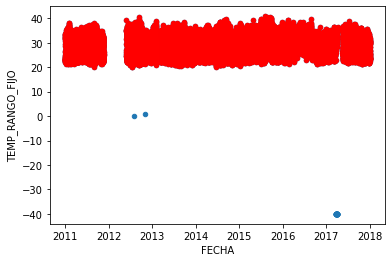

In [22]:
ax = dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP')
dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP_RANGO_FIJO', ax=ax, color='red')

In [23]:
dfTemp['FECHA_DIA'] = dfTemp['FECHA'].dt.date
dfAux = (dfTemp.groupby('FECHA_DIA')
       .agg({'TEMP_RANGO_FIJO': ['mean', 'min', 'max']})
       .reset_index(level = [0])
)
dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))
dfAux['TEMP_MAX_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'max')].shift(1))
dfAux['TEMP_MIN_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'min')].shift(1))

dfCons = (pd.merge(dfTemp,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = {('TEMP_RANGO_FIJO', 'mean') : 'TEMP_PROM_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'min') : 'TEMP_MIN_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'max') : 'TEMP_MAX_DIARIA',
                                 ('TEMP_MAX_D_1', ''): 'TEMP_MAX_D_1',
                              ('TEMP_MIN_D_1', ''): 'TEMP_MIN_D_1',})
        )
dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfCons['TEMP_SH_2'] = (dfCons['TEMP'].shift(1))
dfCons['TEMP_LIST'] = [window.to_list() for window in dfCons['TEMP'].rolling(window=5)]

dfCons['FORM_2_30'] = np.where((dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_PROM_DIARIA']) 
                                    & (dfCons['TEMP_MIN_DIARIA'] < dfCons['TEMP_PROM_DIARIA']), 1, 0)

ant_null_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & df[t_ant].isnull()
ant_notnull_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & ~df[t_ant].isnull()

dfCons['FORM_2_33'] = np.where( (dfCons['FORM_2_30'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MAX_DIARIA', 'TEMP_MIN_D_1')) | (dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_MIN_D_1'])), 1, 0)
dfCons['FORM_2_34'] = np.where( (dfCons['FORM_2_33'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MIN_DIARIA', 'TEMP_MAX_D_1')) | (dfCons['TEMP_MIN_DIARIA'] <= dfCons['TEMP_MAX_D_1'])), 1, 0)
dfCons['FORM_2_35'] = np.where( (dfCons['FORM_2_34'] == 1) & (dfCons['TEMP_MAX_DIARIA'] - dfCons['TEMP_MIN_DIARIA'] < 23.8), 1, 0)
# Ecuación 2.36 --> Si ya tenemos los valores dentro de un rango, para que verificar si tengo tres dias seguidos con t min = 0?

dfCons['FORM_2_37'] = (np.where((dfCons['FORM_2_35'] == 1) & 
                                ((ant_null_act_notnull(dfCons, 'TEMP', 'TEMP_SH_2')) | 
                                 (((~dfCons['TEMP_SH_2'].isnull()) & (~dfCons['TEMP'].isnull())) & 
                                  (np.abs(dfCons['TEMP'] - dfCons['TEMP_SH_2']) < 4))), 1, 0))

# check_size_list = lambda r: 1 if len(list(set([str(x) for x in r]))) == 4 else 0
check_size_list = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 5)) else 1
dfCons['NO_REPETIDO'] = dfCons['TEMP_LIST'].apply(check_size_list)

dfCons['FORM_2_38'] = np.where( (dfCons['FORM_2_37'] == 1) & (dfCons['NO_REPETIDO'] == 1), 1, 0)

####  Quedamos en la formula 2.38 #####

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [24]:
## Para filtrar los valores finales
dfFinal = dfCons[dfCons['FORM_2_38'] == 1].reset_index(drop=True)
dfFinal 

,FECHA,TEMP,TEMP_RANGO_FIJO,FECHA_DIA,TEMP_PROM_DIARIA,TEMP_MIN_DIARIA,TEMP_MAX_DIARIA,TEMP_MAX_D_1,TEMP_MIN_D_1,TEMP_SH_2,TEMP_LIST,FORM_2_30,FORM_2_33,FORM_2_34,FORM_2_35,FORM_2_37,NO_REPETIDO,FORM_2_38
0,2011-01-01 01:00:00-05:00,22.7,22.7,2011-01-01,27.356522,22.7,33.5,NaN,NaN,NaN,[22.7],1,1,1,1,1,1,1
1,2011-01-01 02:00:00-05:00,23.1,23.1,2011-01-01,27.356522,22.7,33.5,NaN,NaN,22.7,"[22.7, 23.1]",1,1,1,1,1,1,1
2,2011-01-01 03:00:00-05:00,23.3,23.3,2011-01-01,27.356522,22.7,33.5,NaN,NaN,23.1,"[22.7, 23.1, 23.3]",1,1,1,1,1,1,1
3,2011-01-01 04:00:00-05:00,24.1,24.1,2011-01-01,27.356522,22.7,33.5,NaN,NaN,23.3,"[22.7, 23.1, 23.3, 24.1]",1,1,1,1,1,1,1
4,2011-01-01 05:00:00-05:00,22.9,22.9,2011-01-01,27.356522,22.7,33.5,NaN,NaN,24.1,"[22.7, 23.1, 23.3, 24.1, 22.9]",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45464,2017-12-31 19:00:00-05:00,25.2,25.2,2017-12-31,26.025000,22.6,30.7,31.9,22.9,26.6,"[30.2, 30.2, 29.7, 26.6, 25.2]",1,1,1,1,1,1,1
45465,2017-12-31 20:00:00-05:00,24.4,24.4,2017-12-31,26.025000,22.6,30.7,31.9,22.9,25.2,"[30.2, 29.7, 26.6, 25.2, 24.4]",1,1,1,1,1,1,1
45466,2017-12-31 21:00:00-05:00,23.9,23.9,2017-12-31,26.025000,22.6,30.7,31.9,22.9,24.4,"[29.7, 26.6, 25.2, 24.4, 23.9]",1,1,1,1,1,1,1
45467,2017-12-31 22:00:00-05:00,24.0,24.0,2017-12-31,26.025000,22.6,30.7,31.9,22.9,23.9,"[26.6, 25.2, 24.4, 23.9, 24.0]",1,1,1,1,1,1,1


In [25]:
print(f'Datos iniciales : {dfTemp.shape[0]}')
print(f'Datos nulos : {dfTemp[dfTemp["TEMP"].isnull()].shape[0]}')
print(f'Datos nulos después de los testes : {dfFinal[dfFinal["TEMP"].isnull()].shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfTemp.shape[0] - dfFinal.shape[0] - dfTemp[dfTemp["TEMP"].isnull()].shape[0]}')

Datos iniciales : 48880
Datos nulos : 2552
Datos nulos después de los testes : 0
Datos finales después de testes : 45469
Datos no nulos que fueron eliminados en los testes : 859


In [26]:
dfFinal[['FECHA', 'TEMP']].to_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';')